<img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/Kaggle_logo.png" align="left" height=100 width=200>

🚀 [**`Kaggle - Machine Learning from Disaster`**](https://www.kaggle.com/c/titanic) 🚀

# ℹ️ Readme

* ✍️ This challenge was written by [davydw](https://github.com/davydw)
* 🎯 The goal is to predict whether a passenger from the Titanic survived or not
* 🚓 It is designed only for Davy's students and cannot be reproduced without davydw's authorization. Indeed, he is no longer working as a full time employee at Le Wagon. Hence, the latter cannot claim and publish this recap on their learning platform `Kitt` without his consent.


# 📚 Libraries

In [33]:
# DATA MANIPULTION
import pandas as pd
import numpy as np

# DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

# STATS
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

# MACHINE LEARNING
## PREPROCESSING
from sklearn.impute import SimpleImputer, KNNImputer
## MODEL SELECTION
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
## SCALERS
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
## CLASSIFICATION MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
## EVALUATION
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_curve
## MODEL TUNING
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# (1) 🛳️ Dataset

❓ Run the following cell to load the `Titanic` dataset

In [34]:
data = sns.load_dataset('titanic').drop(columns=['alive','embarked','pclass'])
data

,survived,sex,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,man,True,NaN,Southampton,False
1,1,female,38.0,1,0,71.2833,First,woman,False,C,Cherbourg,False
2,1,female,26.0,0,0,7.9250,Third,woman,False,NaN,Southampton,True
3,1,female,35.0,1,0,53.1000,First,woman,False,C,Southampton,False
4,0,male,35.0,0,0,8.0500,Third,man,True,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,male,27.0,0,0,13.0000,Second,man,True,NaN,Southampton,True
887,1,female,19.0,0,0,30.0000,First,woman,False,B,Southampton,True
888,0,female,NaN,1,2,23.4500,Third,woman,False,NaN,Southampton,False
889,1,male,26.0,0,0,30.0000,First,man,True,C,Cherbourg,True


❓ What are the different types of columns in this dataset?

In [35]:
data.dtypes

survived          int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alone              bool
dtype: object

In [36]:
data.describe()

,survived,age,sibsp,parch,fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [37]:
data.dtypes

survived          int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alone              bool
dtype: object

# (2) 🧹 Cleaning the dataset

## (2.1) 👥 Duplicates ?

❓ How many duplicated rows does this dataset have?

In [38]:
data.shape

(891, 12)

In [39]:
data.duplicated().sum()

107

❓ Remove them

In [40]:
data.drop_duplicates(inplace=True)
data.shape

(784, 12)

## (2.2) ❓ Missing values

❓ Where are the missing values of the dataset?

* Drop what seems unusable or useless
* Impute the missing values where needed

In [41]:
data.isnull().sum()

survived         0
sex              0
age            106
sibsp            0
parch            0
fare             0
class            0
who              0
adult_male       0
deck           582
embark_town      2
alone            0
dtype: int64

In [42]:
data.isnull().sum()/data.shape[0]

survived       0.000000
sex            0.000000
age            0.135204
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.742347
embark_town    0.002551
alone          0.000000
dtype: float64

In [43]:
# ** Age **
# With only 13% I want to avoid dropping the column altogether
# Let's impute the median -- although, I wonder if unknown age is more common
# for specific groups?
median_imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
median_imputer.fit(data[["age"]])
data["age"] = median_imputer.transform(data[["age"]])

# Verify that the median is the most common age
data["age"].value_counts().head(2)

28.25    106
24.00     29
Name: age, dtype: int64

In [44]:
# **deck**
# Majority of rows missing value, let's drop! May also be redundant with Class.
data.drop("deck", axis=1, inplace=True)

In [45]:
# **embark_town**
# Only two missing! This is a categorical feature, let's have a look.
data["embark_town"].value_counts(dropna=False)
# I'm turn between imputing the most common value or just saying "unknown".

Southampton    568
Cherbourg      155
Queenstown      59
NaN              2
Name: embark_town, dtype: int64

In [46]:
# Let's impute the most common value.
mode_imputer = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")
mode_imputer.fit(data[["embark_town"]])
data["embark_town"] = mode_imputer.transform(data[["embark_town"]])
data["embark_town"].value_counts(dropna=False)

Southampton    570
Cherbourg      155
Queenstown      59
Name: embark_town, dtype: int64

In [47]:
data.isnull().sum()

survived       0
sex            0
age            0
sibsp          0
parch          0
fare           0
class          0
who            0
adult_male     0
embark_town    0
alone          0
dtype: int64

## (2.3) 🎯 Define features and target

In [48]:
X = data.drop("survived", axis=1)
y = data["survived"]

## (2.4) ✂️ Holdout method

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## (2.5) 🔢 Scaling numerical features

❓ Create a variable `X_train_num` and a variable `X_test_num` where you will store all your numerical features

In [50]:
X_train_num = X_train.select_dtypes(include=["float64", "int64"])
X_test_num = X_test.select_dtypes(include=["float64", "int64"])

❓ Choose one scaler and scale both `X_train_num` and `X_test_num` into two variables `X_train_num_scaled` and `X_test_num_scaled`

Do not waste too much time here. You can always go back to this section of the notebook later.

In [51]:
robust_scaler = RobustScaler().set_output(transform="pandas")

In [52]:
X_train_num_scaled = robust_scaler.fit(X_train_num).transform(X_train_num)
X_train_num_scaled.head(1)

,age,sibsp,parch,fare
888,0.0,1.0,8.0,0.202186


In [53]:
X_test_num_scaled = robust_scaler.fit(X_test_num).transform(X_test_num)
X_test_num_scaled.head(1)

,age,sibsp,parch,fare
784,-0.22807,0.0,0.0,-0.337486


## (2.6) 🔡 Encoding categorical features

❓ Create a variable `X_train_cat` and a variable `X_test_cat` where you will store all your categorical features

In [54]:
X_train_cat = X_train.select_dtypes(include=["category"])
X_train_cat.value_counts()

class 
Third     270
First     160
Second    118
dtype: int64

In [55]:
X_test_cat = X_test.select_dtypes(include=["category"])
X_test_cat.value_counts()

class 
Third     135
First      54
Second     47
dtype: int64

### (2.6.0) How many columns are expected ?

❓ How many columns do you expect to generate if you encode these categorical features?

In [56]:
# No additional ones for the above as I used ordinal encoder.
# For gender one additional, for for embark_town two.

### (2.6.1) OneHotEncoder

❓ Store the list of features you want to OHE into a variable called `features_ohe`

In [57]:
features_ohe = ["embark_town", "sex"]

❓ Encode them and store them into `X_train_cat_encoded` and `X_test_cat_encoded`

In [58]:
ohe_encoder = OneHotEncoder(drop="first", sparse_output=False).set_output(transform="pandas")

In [59]:
X_train_cat_encoded = ohe_encoder.fit(X_train[features_ohe]).transform(
    X_train[features_ohe])

X_train_cat_encoded.head(1)

,embark_town_Queenstown,embark_town_Southampton,sex_male
888,0.0,1.0,0.0


In [60]:
X_test_cat_encoded = ohe_encoder.fit(
    X_test[features_ohe]
).transform(X_test[features_ohe])

X_test_cat_encoded.head(1)

,embark_town_Queenstown,embark_town_Southampton,sex_male
784,0.0,1.0,1.0


### (2.6.2) OrdinalEncoder

❓ Store the list of features you want to OrdinalEncoder into a variable called `features_ordinal`

In [61]:
class_categories = ["First", "Second", "Third"]
ordinal_encoder = OrdinalEncoder(categories=[class_categories]).set_output(
    transform="pandas"
)

❓ Encode them and store them into `X_train_ordinal` and `X_test_ordinal`

In [62]:
X_train_ordinal = ordinal_encoder.fit(X_train_cat).transform(X_train_cat)
X_train_ordinal.value_counts()

class
2.0      270
0.0      160
1.0      118
dtype: int64

In [63]:
X_test_ordinal = ordinal_encoder.fit(X_test_cat).transform(X_test_cat)
X_test_ordinal.value_counts()

class
2.0      135
0.0       54
1.0       47
dtype: int64

# (2.7) ⛓️ Concatenating

❓ Create `train_processed` which is the concatenation of `X_train_num_scaled`, `X_train_cat_encoded` and `X_train_ordinal`. Do the same for `test_processed`

In [64]:
train_processed = pd.concat([X_train_num_scaled, X_train_cat_encoded, X_train_ordinal], axis=1)
train_processed.head(1)

,age,sibsp,parch,fare,embark_town_Queenstown,embark_town_Southampton,sex_male,class
888,0.0,1.0,8.0,0.202186,0.0,1.0,0.0,2.0


In [65]:
test_processed = pd.concat([X_test_num_scaled, X_test_cat_encoded, X_test_ordinal], axis=1)
test_processed.head(1)

,age,sibsp,parch,fare,embark_town_Queenstown,embark_town_Southampton,sex_male,class
784,-0.22807,0.0,0.0,-0.337486,0.0,1.0,1.0,2.0


In [68]:
train_processed.shape

(548, 8)

In [69]:
test_processed.shape

(236, 8)

In [ ]:
y.shape

# (2.8) 🐣 Baseline Model - Most Frequent

❓ What would be a baseline model for a classification task?

Compute the accuracy of this baseline model and store it into `accuracy_baseline`

In [66]:
from sklearn.dummy import DummyClassifier

In [76]:
baseline_model = DummyClassifier()
baseline_model.fit(train_processed, y_train)
accuracy_baseline = cross_validate(baseline_model, train_processed, y_train)["test_score"].mean()
accuracy_baseline

0.5875896580483737

❓ Print the confusion matrix of this baseline model

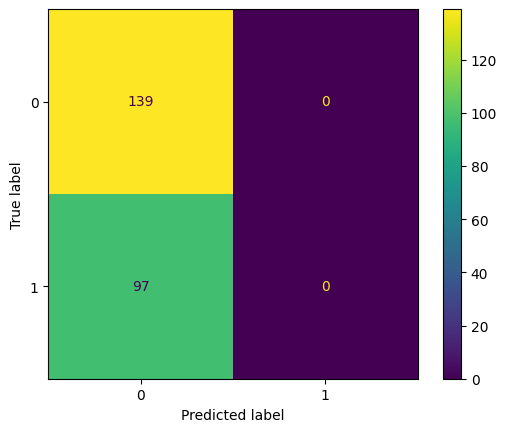

In [73]:
predictions = baseline_model.predict(test_processed)
cm = confusion_matrix(y_test, predictions, labels=baseline_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=baseline_model.classes_)
disp.plot()
plt.show()

# (2.9) 💪Logistic Regression

❓ Instead of using the baseline model, try a LogisticRegression

Compute the accuracy of this LogisticRegression and store it into `accuracy_logisitic`

In [78]:
log_res = LogisticRegression()
log_res.fit(train_processed, y_train)
accuracy_logistic = cross_validate(log_res, train_processed, y_train)["test_score"].mean()

accuracy_logistic

0.7645037531276063

❓ Print the confusion matrix of this Logistic Regression

# (2.10) 🧨Threshold adjustment

👇 Imagine that the target recall is 0.95

In [ ]:
targeted_recall = 0.95

❓Run a threshold adjustment process to find the probability threshold leading to such a targeted recall

❓ Print the confusion matrix and the classification report with this new threshold to double-check that you reached a recall of 0.95.

# (2.11) 🧑🏻‍🔬 Trying advanced models

For each of the advanced models>
1. GridSearchCV to optimise their hyperparamters
2. ConfusionMatrix
3. CM after a threshold adjustment

### (2.11.1) KNeighborsClassifier

***ConfusionMatrix of the KNC before threshold adjustment***

***ConfusionMatrix of the KNC after threshold adjustment***

### (2.11.2) Support Vector Classifiers

***ConfusionMatrix of the SVC before threshold adjustment***

***ConfusionMatrix of the SVC after threshold adjustment***

# (2.12) 📊 Comparing models

❓ What conclusions can you draw?

🏁 🏁 🏁 Congratulations! If you went to the end of this notebook, you understood most of the Machine Learning Techniques learned during **Le Wagon Data Science Bootcamp - Machine Learning I**.



# Author of this challenge: [DavyDW](https://www.linkedin.com/in/davywai/)